# **Final Project**

## **Imports and Helper Functions**

In [2]:
%pip install tensorflow
%pip install matplotlib
%pip install opencv-python
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from keras.layers import Conv2D, UpSampling2D, Input, Lambda, MaxPool2D, Reshape
from keras.models import Sequential, Model
from keras.losses import MeanSquaredError
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import cv2

2024-05-18 23:36:12.695525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 8
RESOLUTION = (480, 360)

print("GPUs Available: ", str(tf.config.experimental.list_physical_devices('GPU')))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def fetch_images(generator, num_images=9):
    """
    Fetches a set of images from the generator.
    
    :param generator: An instance of ImageDataGenerator.
    :param num_images: Number of images to fetch.
    :return: List of tuples containing input and output images.
    """
    images = []
    batch_window = len(generator) // num_images
    generator.on_epoch_end() # Shuffle
    inputs, outputs = generator.__getitem__(0)
    images = [(x, y) for (x, y) in zip(inputs, outputs)]
    return images

def plot_images(generator, num_images=9):
    """
    Plots a grid of input, output, and combined images using images fetched from the generator.
    
    :param generator: An instance of ImageDataGenerator.
    :param num_images: Total number of images to display in a grid. Ideally, this should be 9 for 3 rows of 3.
    """

    # input_output_examples = fetch_images(generator, num_images)

    inputs, outputs = generator.__getitem__(0)

    num_rows = min(num_images, generator.batch_size, len(inputs))

    # Create a subplot grid
    fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, num_rows * 5))
    
    # Flatten the array of axes (for easier indexing)
    axs = axs.flatten()

    print("input specs:", inputs.shape, "min: ", np.min(inputs), "max:", np.max(inputs))
    print("output specs:", outputs.shape, "min: ", np.min(outputs), "max:", np.max(outputs))

    for i in range(num_rows):
        
        # Plot grayscale input image.
        axs[3*i].imshow(inputs[i][:,:,0]*255, cmap='gray')
        axs[3*i].set_title("IN (L)")
        axs[3*i].axis('off')

        # Convert LAB AB channels back to RGB for visualization.
        lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
        lab_image[:, :, 0] = 100  # Set a fixed L channel.
        lab_image[:, :, 1:] = outputs[i]*127.5+127.5
        rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
        axs[3*i+1].imshow(rgb_image)
        axs[3*i+1].set_title("OUT (AB)")
        axs[3*i+1].axis('off')

        # Create combined image using grayscale as L channel and AB from output
        combined_lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
        combined_lab_image[:, :, 0] = inputs[i][:,:,0]*255  # Use the grayscale image as the L channel
        combined_lab_image[:, :, 1:] = outputs[i]*127.5+127.5
        combined_rgb_image = cv2.cvtColor(combined_lab_image, cv2.COLOR_LAB2RGB)
        axs[3*i+2].imshow(combined_rgb_image)
        axs[3*i+2].set_title("Combined (L+AB)")
        axs[3*i+2].axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    Plots the training and validation loss from the history object of a model training session.

    Args:
    history (History): The History object from the TensorFlow/Keras model training session.
    """
    # Extracting the loss history for plotting
    training_loss = history.history['loss']
    epochs = range(1, len(training_loss) + 1)

    # Setting up the plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_loss, 'bo-', label='Training Loss')

    # Check if validation loss is present in the history
    if 'val_loss' in history.history:
        validation_loss = history.history['val_loss']
        plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')

    # Adding plot labels and title
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_colorization_results(orig_image, predicted_ab, resolution, factor = 1):
    """
    Plots the original image, the grayscale version, and various stages of colorization.
    
    Args:
    orig_image (numpy array): The original RGB image.
    predicted_ab (numpy array): The predicted AB channels from the autoencoder.
    resolution (tuple): The (width, height) resolution to which images are resized.
    """
    FACTOR = factor # if == 1: unused
    plt.figure(figsize=(5, 15))  # Create a figure with appropriate size

    # Original Image
    ax = plt.subplot(5, 1, 1)
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Convert to LAB to extract L channel
    img_lab = cv2.cvtColor(orig_image, cv2.COLOR_BGR2LAB)
    l_channel = img_lab[:, :, 0]

    # Grayscale Image (L channel)
    ax = plt.subplot(5, 1, 2)
    plt.imshow(l_channel, cmap='gray')
    plt.title("Grayscale L Channel")
    plt.axis('off')

    # Display the AB channels as an image (just for visual insight, may not be meaningful)
    # ax = plt.subplot(5, 1, 3)
    # ab_image = np.zeros((resolution[1], resolution[0], 3), dtype=np.uint8)
    # ab_image[:, :, 1:] = predicted_ab*127.5 +127.5
    # plt.imshow(cv2.cvtColor(ab_image, cv2.COLOR_LAB2RGB))
    # plt.title("Predicted AB Channels")
    # plt.axis('off')

    # Predicted AB (fixed L = 100)
    ax = plt.subplot(5, 1, 3)
    combined_lab_fixed = np.zeros((resolution[1], resolution[0], 3), dtype=np.uint8)
    combined_lab_fixed[:, :, 0] = 100
    combined_lab_fixed[:, :, 1:] = predicted_ab *(127.5 * FACTOR) +127.5
    plt.imshow(cv2.cvtColor(combined_lab_fixed, cv2.COLOR_LAB2RGB))
    plt.title("Predicted AB (Fixed L=100)")
    plt.axis('off')

    # Predicted AB (original L channel)
    ax = plt.subplot(5, 1, 4)
    combined_lab_original = np.zeros((resolution[1], resolution[0], 3), dtype=np.uint8)
    combined_lab_original[:, :, 0] = l_channel
    combined_lab_original[:, :, 1:] = predicted_ab *(127.5 * FACTOR) +127.5
    plt.imshow(cv2.cvtColor(combined_lab_original, cv2.COLOR_LAB2RGB))
    plt.title("Combined Image (Original L)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def display_img(img, gray = False): 
    cmap = 'gray' if gray else None
    plt.imshow(img, cmap=cmap) 
    plt.axis('off')  # Hide the axis
    plt.show()

## **Preprocessing and Augmentation**

epoch ended
input specs: (32, 360, 480, 3) min:  0.0 max: 1.0
output specs: (32, 360, 480, 2) min:  -0.4745098039215686 max: 0.6313725490196078


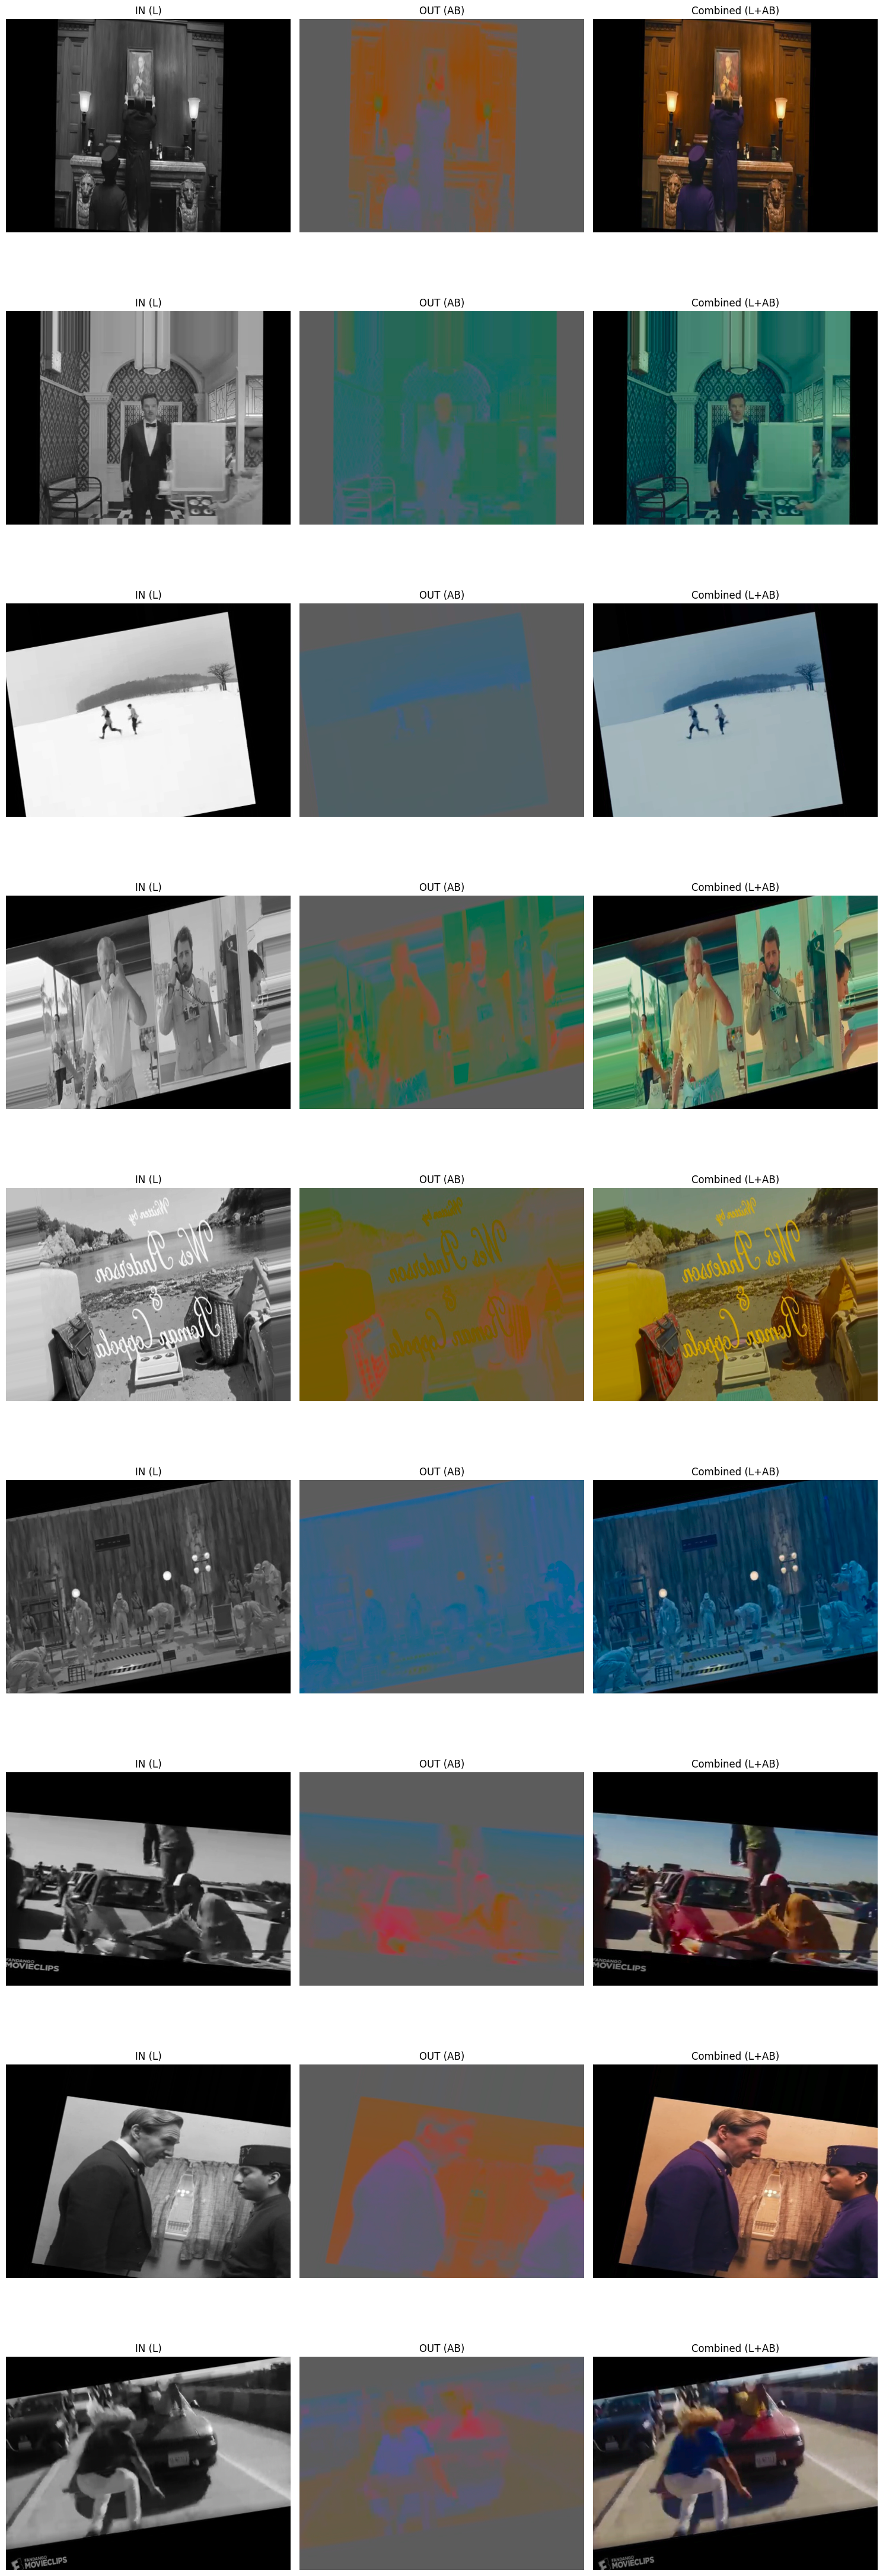

In [4]:
import src.Tyler_ImageDataGenerator as tyler_image_generator
importlib.reload(tyler_image_generator)

# Create data generator
train_directory = 'data/vibrant_movie_frames/rgb'
train_generator = tyler_image_generator.ImageDataGenerator(train_directory, resolution=RESOLUTION)

# Print examples from generator
plot_images(train_generator)



## **Model Architecture**

In [7]:
gpus = tf.config.list_physical_devices()
if gpus:
    print("GPUs available:", gpus)
else:
    print("No GPU found.")

GPUs available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
import socket
hostname = socket.gethostname()
print("Hostname:", hostname)

Hostname: fowler-lpw-dgx-0


In [5]:
# Define encoder
#
encoder_input_shape: tuple = (RESOLUTION[::-1] + (3,)) # Add color dim to input shape
encoder: Model = VGG16(include_top=False, weights='imagenet', input_shape=encoder_input_shape)

# Freeze the pretrained layers
# The whole reason we are using VGG16
for layer in encoder.layers:
    layer.trainable = False

# Set the last two layers to trainable
encoder.layers[-1].trainable = True
# encoder.layers[-2].trainable = True
# encoder.layers[0].trainable = True

# Access the output shape of the encoder
encoder_output_shape = encoder.output_shape[1:] # Drop batch size element
print('VGG16-based encoder input: ' + str(encoder_input_shape))
print('latent shape: ' + str(encoder_output_shape))


# Define decoder
#
decoder = Sequential(
    [
        Input(shape=encoder_output_shape),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3,3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(2, (3, 3), activation='tanh', padding='same'),
        UpSampling2D((2, 2)),
        Lambda(lambda x: tf.image.resize(x, RESOLUTION[::-1], method=tf.image.ResizeMethod.BILINEAR))
    ],
    name='ColorizationDecoder'
)

# Access the output shape of the decoder
decoder_output_shape = decoder.output_shape[1:] # Drop batch size element
print('Decoder output shape: ' + str(decoder_output_shape))

# Summary of models
# encoder.summary()
# decoder.summary()

# Create an encoder-decoder model
input_img = Input(shape=encoder_input_shape)
encoded_img = encoder(input_img)
decoded_img = decoder(encoded_img)

autoencoder = Model(input_img, decoded_img)
autoencoder.compile(optimizer=Adam(learning_rate=.0015), loss='mse')  # Using mean squared error loss, adjust if necessary
autoencoder.summary()

2024-05-18 23:36:33.493185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79091 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


VGG16-based encoder input: (360, 480, 3)
latent shape: (11, 15, 512)
Decoder output shape: (360, 480, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 360, 480, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 11, 15, 512)       14714688  
                                                                 
 ColorizationDecoder (Seque  (None, 360, 480, 2)       1572114   
 ntial)                                                          
                                                                 
Total params: 16286802 (62.13 MB)
Trainable params: 1572114 (6.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## **Training**

In [6]:
# Train the model
history = autoencoder.fit(
    x=train_generator,
    epochs=50,  # Set the number of epochs according to your needs
    verbose=1
)

Epoch 1/50


2024-05-18 23:36:49.894470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-05-18 23:36:53.605442: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xba690f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-18 23:36:53.605497: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-05-18 23:36:53.609715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-18 23:36:53.717562: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 [==============================] - 115s 1s/step - loss: 0.0264
epoch ended
Epoch 2/50
91/91 [==============================] - 111s 1s/step - loss: 0.0103
epoch ended
Epoch 3/50
91/91 [==============================] - 111s 1s/step - loss: 0.0100
epoch ended
Epoch 4/50
91/91 [==============================] - 113s 1s/step - loss: 0.0098
epoch ended
Epoch 5/50
91/91 [==============================] - 111s 1s/step - loss: 0.0097
epoch ended
Epoch 6/50
91/91 [==============================] - 111s 1s/step - loss: 0.0096
epoch ended
Epoch 7/50
91/91 [==============================] - 111s 1s/step - loss: 0.0093
epoch ended
Epoch 8/50
91/91 [==============================] - 110s 1s/step - loss: 0.0093
epoch ended
Epoch 9/50
91/91 [==============================] - 111s 1s/step - loss: 0.0092
epoch ended
Epoch 10/50
91/91 [==============================] - 111s 1s/step - loss: 0.0091
epoch ended
Epoch 11/50
91/91 [==============================] - 111s 1s/step - loss: 0.0090
epoch end

In [12]:
# Train the model
history = autoencoder.fit(
    x=train_generator,
    epochs=5,  # Set the number of epochs according to your needs
    verbose=1
)

Epoch 1/5
91/91 [==============================] - 111s 1s/step - loss: 0.0153
epoch ended
Epoch 2/5
91/91 [==============================] - 111s 1s/step - loss: 0.0107
epoch ended
Epoch 3/5
91/91 [==============================] - 112s 1s/step - loss: 0.0103
epoch ended
Epoch 4/5
91/91 [==============================] - 111s 1s/step - loss: 0.0101
epoch ended
Epoch 5/5
91/91 [==============================] - 111s 1s/step - loss: 0.0099
epoch ended


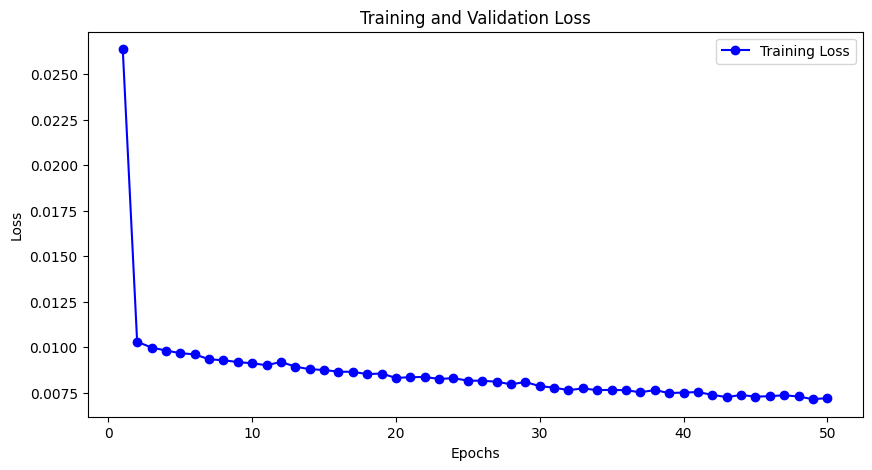

In [7]:
plot_training_history(history)

1/1 [==============================] - 0s 38ms/step


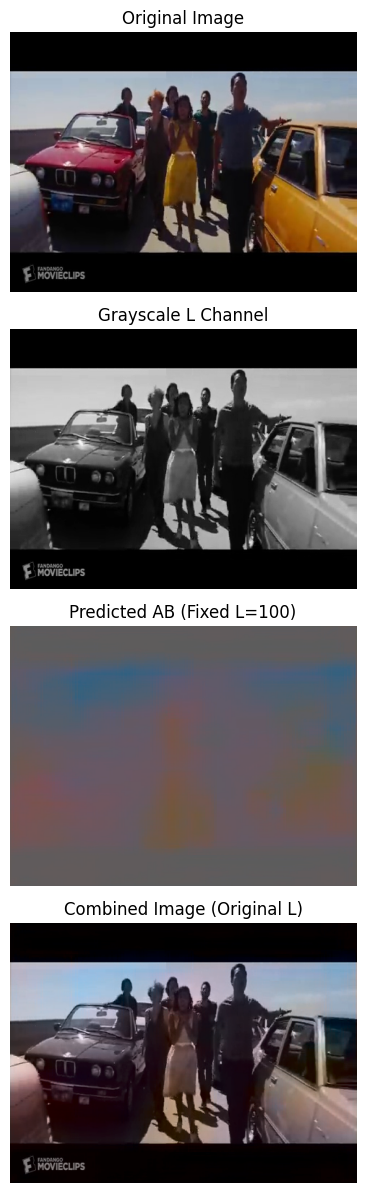

In [45]:
# Example usage of the function
testpath = 'data/vibrant_movie_frames/rgb/8_rgb_110.jpeg'
img = cv2.imread(testpath)
img = cv2.resize(img, (RESOLUTION[0], RESOLUTION[1]))  # Resize image if needed
l = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:,:,0]/255
l = np.stack((l,)*3, axis=-1)
l_input = l.reshape((1, RESOLUTION[1], RESOLUTION[0], 3))  # Notice height and width positions are switched
output = autoencoder.predict(l_input)
# output = autoencoder.predict(l_img)
plot_colorization_results(img, output, RESOLUTION, factor = 2)

In [ ]:
autoencoder.save('colorize_model_may18_10epoch_unfrozen_last2_layers.h5')

epoch ended
1/1 [==============================] - 0s 65ms/step


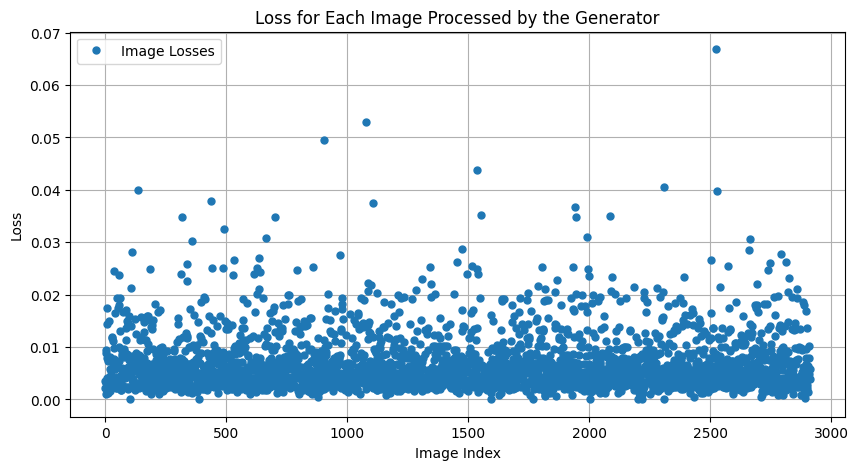

In [21]:
def plot_image_losses(generator, model):
    """
    Evaluates images from a generator using a model and plots the loss for each image.
    
    Args:
    generator (Generator): A data generator that yields batches of input data and targets.
    model (tf.keras.Model): A trained TensorFlow/Keras model.
    """
    losses = []

    # Process all batches provided by the generator
    for batch in generator:
        inputs, targets = batch
        # Predict the outputs
        predictions = model.predict(inputs)
        # Calculate MSE loss for each image in the batch
        batch_losses = np.mean(np.square(predictions - targets), axis=(1, 2, 3))
        
        # Store losses
        losses.extend(batch_losses)
    
    # Convert losses to a numpy array for easier handling
    losses = np.array(losses)
    
    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='', markersize=5, label='Image Losses')
    plt.title('Loss for Each Image Processed by the Generator')
    plt.xlabel('Image Index')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


test_directory = 'data/vibrant_movie_frames/rgb'
test_generator = tyler_image_generator.ImageDataGenerator(train_directory, is_train=False, resolution=RESOLUTION)
plot_image_losses(test_generator, autoencoder)

## **Validation after 5 epochs, -1,-2 unfrozen**

1/1 [==============================] - 0s 55ms/step


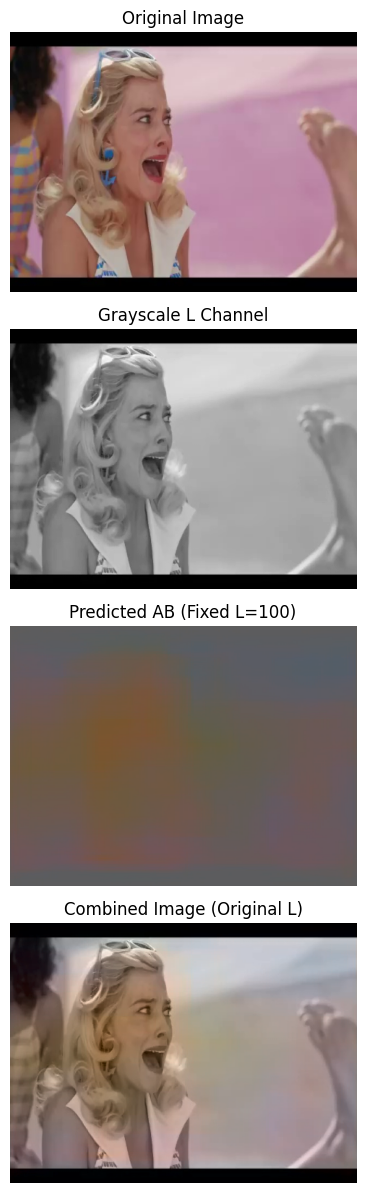

In [17]:
# Example usage of the function
testpath = 'data/vibrant_movie_frames/rgb/2_rgb_120.jpeg'
img = cv2.imread(testpath)
img = cv2.resize(img, (RESOLUTION[0], RESOLUTION[1]))  # Resize image if needed
l = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:,:,0]/255
l = np.stack((l,)*3, axis=-1)
l_input = l.reshape((1, RESOLUTION[1], RESOLUTION[0], 3))  # Notice height and width positions are switched
output = autoencoder.predict(l_input)
# output = autoencoder.predict(l_img)
plot_colorization_results(img, output, RESOLUTION)

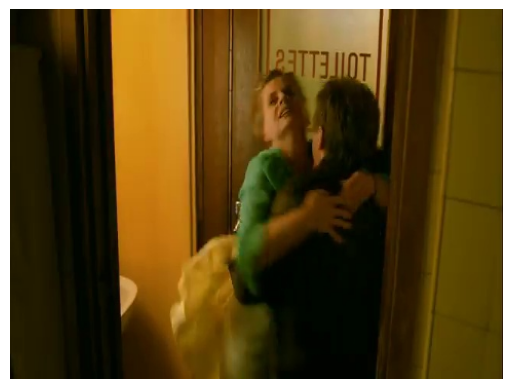

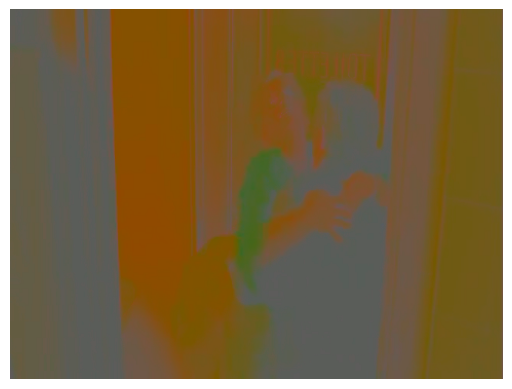

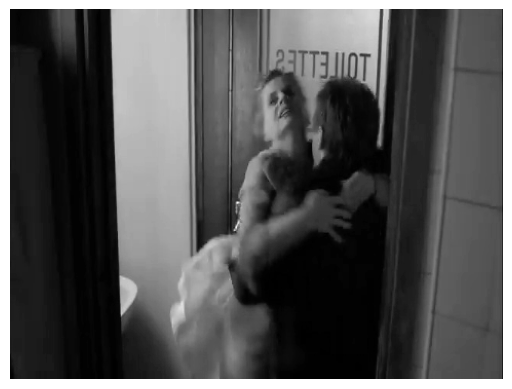

1/1 [==============================] - 0s 36ms/step


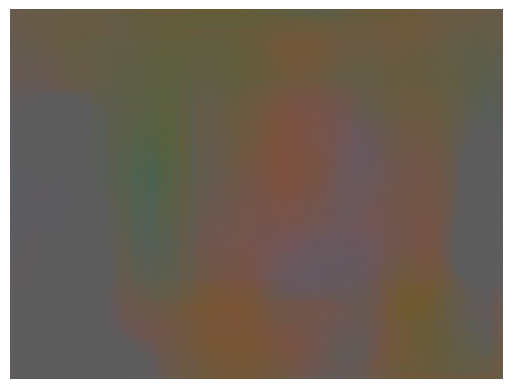

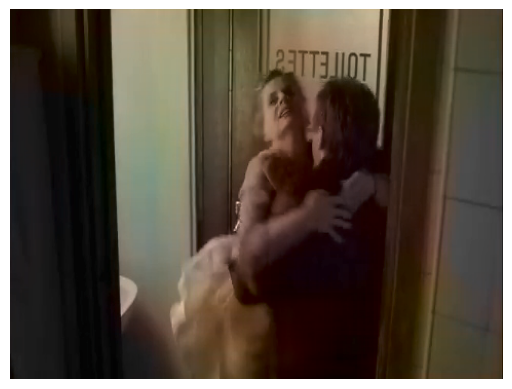

(1, 360, 480, 3) (1, 360, 480, 2)
Minimum (in) Value: 0.00392156862745098
Maximum (in) Value: 0.8823529411764706
Minimum (out) Value: -0.061874382
Maximum (out) Value: 0.15701531


In [ ]:
testpath = 'data/vibrant_movie_frames/rgb/3_rgb_98.jpeg'
# testpath = 'rundir/CPSC542_final_project/data/vibrant_movie_frames/rgb/12_rgb_71.jpeg'
# testpath = 'rundir/CPSC542_final_project/data/vibrant_movie_frames/rgb/6_rgb_221.jpeg'

img = cv2.imread(testpath)
img = cv2.resize(img, (RESOLUTION[0], RESOLUTION[1]))  # Correcting to use width x height
display_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

disp_imglab = imglab
disp_imglab[:, :, 0] = 100
display_img(cv2.cvtColor(disp_imglab, cv2.COLOR_LAB2RGB))
imglab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l = imglab[:, :, 0]/255
display_img(l, gray=True)
# print("Maximum Value:", np.max(l))
l = np.stack((l,)*3, axis=-1)
l_input = l.reshape((1, RESOLUTION[1], RESOLUTION[0], 3))  # Notice height and width positions are switched

output = autoencoder.predict(l_input)

combined_lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
combined_lab_image[:, :, 0] = 100
combined_lab_image[:, :, 1:] = (output*127.5*1.5) +127.5

display_img(cv2.cvtColor(combined_lab_image, cv2.COLOR_LAB2RGB))

combined_lab_image[:, :, 0] = l[:,:,0]*255  # Use the grayscale image as the L channel

display_img(cv2.cvtColor(combined_lab_image, cv2.COLOR_LAB2RGB))

print(l_input.shape,output.shape)
print("Minimum (in) Value:", np.min(l))
print("Maximum (in) Value:", np.max(l))
print("Minimum (out) Value:", np.min(output))
print("Maximum (out) Value:", np.max(output))



## **Validation after 10 epochs, -1,-2 unfrozen**

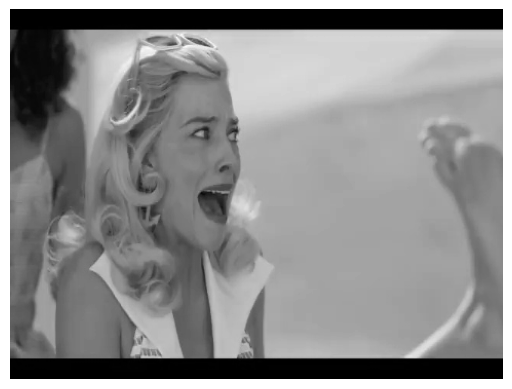

Maximum Value: 0.9725490196078431
1/1 [==============================] - 0s 38ms/step


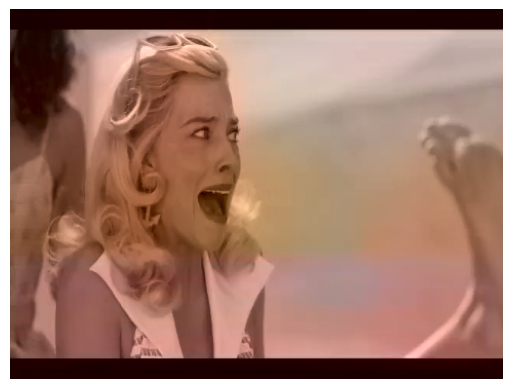

(1, 360, 480, 3) (1, 360, 480, 2)
Minimum Value: 0.0
Maximum Value: 0.9725490196078431
Minimum Value: -0.057390947
Maximum Value: 0.18918717


In [ ]:
testpath = 'data/vibrant_movie_frames/rgb/2_rgb_120.jpeg'
# testpath = 'rundir/CPSC542_final_project/data/vibrant_movie_frames/rgb/12_rgb_71.jpeg'
# testpath = 'rundir/CPSC542_final_project/data/vibrant_movie_frames/rgb/6_rgb_221.jpeg'

img = cv2.imread(testpath)
img = cv2.resize(img, (RESOLUTION[0], RESOLUTION[1]))  # Correcting to use width x height

imglab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
l = imglab[:, :, 0]/255
display_img(l, gray=True)
print("Maximum Value:", np.max(l))
l = np.stack((l,)*3, axis=-1)
l_input = l.reshape((1, RESOLUTION[1], RESOLUTION[0], 3))  # Notice height and width positions are switched

output = autoencoder.predict(l_input)

combined_lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
combined_lab_image[:, :, 0] = l[:,:,0]*255  # Use the grayscale image as the L channel
combined_lab_image[:, :, 1:] = (output*127.5) +137.5
combined_rgb_image = cv2.cvtColor(combined_lab_image, cv2.COLOR_LAB2RGB)

display_img(combined_rgb_image)

print(l_input.shape,output.shape)
print("Minimum Value:", np.min(l))
print("Maximum Value:", np.max(l))
print("Minimum Value:", np.min(output))
print("Maximum Value:", np.max(output))

## **Visual evaluation with layers -1,-2,-4 unfrozen:**

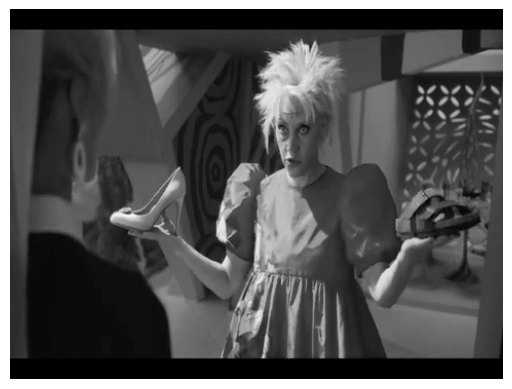

Maximum Value: 0.9725490196078431
1/1 [==============================] - 0s 36ms/step


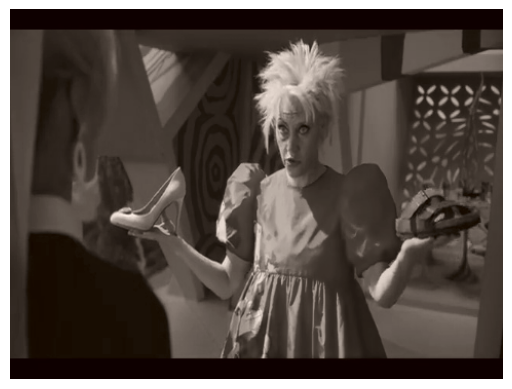

(1, 360, 480, 3) (1, 360, 480, 2)
Minimum Value: 0.0
Maximum Value: 0.9725490196078431
Minimum Value: 0.03473157
Maximum Value: 0.054190423


In [ ]:
testpath = 'data/vibrant_movie_frames/rgb/2_rgb_146.jpeg'
# testpath = 'rundir/CPSC542_final_project/data/vibrant_movie_frames/rgb/12_rgb_71.jpeg'
# testpath = 'rundir/CPSC542_final_project/data/vibrant_movie_frames/rgb/6_rgb_221.jpeg'

# Assuming testpath is defined and points to a valid image file
img = cv2.imread(testpath)
# Ensure the resolution is specified correctly. cv2.resize expects (width, height).
img = cv2.resize(img, (RESOLUTION[0], RESOLUTION[1]))  # Correcting to use width x height

imglab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

# Extract the L channel
l = imglab[:, :, 0]/255
display_img(l, gray=True)
print("Maximum Value:", np.max(l))
# Stack the L channel into three channels
l = np.stack((l,)*3, axis=-1)

# The RESOLUTION should match the dimensions of l_input
# l_input should be reshaped to (batch, height, width, colors)
l_input = l.reshape((1, RESOLUTION[1], RESOLUTION[0], 3))  # Notice height and width positions are switched
# resized_gray_image_rgb = np.stack((l,) * 3, axis=-1)
# display_img(l, gray=True)

output = autoencoder.predict(l_input)

combined_lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
combined_lab_image[:, :, 0] = l[:,:,0]*255  # Use the grayscale image as the L channel
combined_lab_image[:, :, 1:] = (output*127.5) +127.5
combined_rgb_image = cv2.cvtColor(combined_lab_image, cv2.COLOR_LAB2RGB)

display_img(combined_rgb_image)

print(l_input.shape,output.shape)
print("Minimum Value:", np.min(l))
print("Maximum Value:", np.max(l))
print("Minimum Value:", np.min(output))
print("Maximum Value:", np.max(output))


# # Assuming testpath is defined and points to a valid image file
# img = cv2.imread(testpath)
# # Ensure the resolution is specified correctly. cv2.resize expects (width, height).
# img = cv2.resize(img, (RESOLUTION[0], RESOLUTION[1]))  # Correcting to use width x height
# imglab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

# # Extract the L channel
# l = imglab[:, :, 0]

# # Stack the L channel into three channels
# l = np.stack((l,)*3, axis=-1)

# # The RESOLUTION should match the dimensions of l_input
# # If RESOLUTION is (width, height), then l_input should be reshaped to (1, height, width, 3)
# l_input = l.reshape((1, RESOLUTION[1], RESOLUTION[0], 3))  # Notice height and width positions are switched
# # resized_gray_image_rgb = np.stack((l,) * 3, axis=-1)
# # display_img(l, gray=True)

# output = autoencoder.predict(l_input)

# combined_lab_image = np.zeros((RESOLUTION[::-1] + (3,)), dtype=np.uint8)
# combined_lab_image[:, :, 0] = l[:,:,0]  # Use the grayscale image as the L channel
# combined_lab_image[:, :, 1:] = output[0]*37.5 + 127.5
# combined_rgb_image = cv2.cvtColor(combined_lab_image, cv2.COLOR_LAB2RGB)

# display_img(combined_rgb_image, gray=True)